# Utilisation API EDR

L'api est mise à disposition par géosas : [https://api.geosas.fr/edr/collections/](https://api.geosas.fr/edr/collections/) 


## Exemple des données SAFRAN

Prise en main de l'API et de xarray par une étude de la température moyenne en France métropolitaine

In [88]:
import requests
import xarray as xr
import numpy as np

In [9]:
coord='25129,6033881,1319206,7310535'

In [17]:
%%time
param='code_culture'
r=requests.get(f'https://api.geosas.fr/edr/collections/safran-isba/cube?bbox={coord}&crs=EPSG:2154&parameter-name=T_Q&f=Netcdf4&datetime=1960-01-01/2024-01-01')


CPU times: user 3.11 s, sys: 2.13 s, total: 5.25 s
Wall time: 47.5 s


Affichage des informations du jeu de données

In [18]:
data=xr.open_dataset(r.content)

In [19]:
data

<xarray.Dataset>
Dimensions:      (time: 23377, y: 135, x: 144)
Coordinates:
  * time         (time) datetime64[ns] 1960-01-01 1960-01-02 ... 2024-01-01
  * x            (x) float64 1.052e+05 1.132e+05 ... 1.24e+06 1.248e+06
  * y            (y) float64 7.119e+06 7.111e+06 ... 6.056e+06 6.048e+06
Data variables:
    T_Q          (time, y, x) float32 ...
    spatial_ref  int32 ...
Attributes:
    description:  Données quotidiennes du modèle de simulation des schémas de...
    id:           safran-isba
    title:        Safran-Isba, Données changement climatique - SIM quotidienne
    crs:          EPSG:2154
    rel:          https://www.etalab.gouv.fr/licence-ouverte-open-licence/

In [53]:
data.T_Q.attrs

{'description': 'Température (moyenne quotidienne)',
 'observedProperty': 'http://opendata.inrae.fr/thesaurusINRAE/c_1243',
 'type': 'Parameter',
 'unit': '°C',
 'unit label': 'degrée Celcius'}

### Température moyenne sur toute la période

CPU times: user 1.89 s, sys: 625 ms, total: 2.51 s
Wall time: 2.51 s


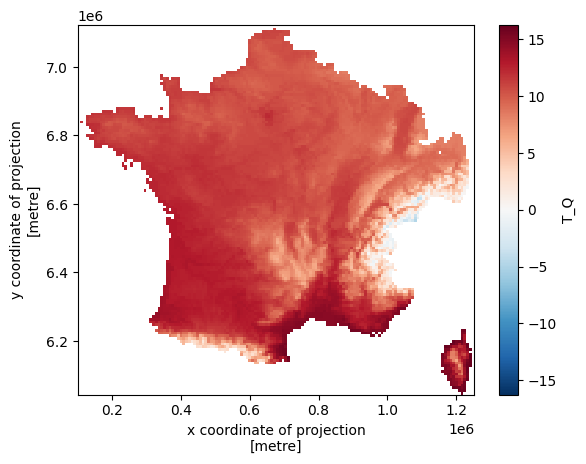

In [24]:
%%time
data.T_Q.mean('time').plot()

### Moyenne de toutes les valeurs ( par xarray ou numpy)

In [52]:
%%time
print(data.T_Q.mean().data)

10.354041
CPU times: user 1.69 s, sys: 617 ms, total: 2.31 s
Wall time: 2.3 s


In [39]:
%%time
print(np.nanmean(data.T_Q.data))

10.354041
CPU times: user 1.67 s, sys: 615 ms, total: 2.29 s
Wall time: 2.29 s


### Sélection des données par filtre temporelle

In [62]:
data1=data.sel({'time':slice("1960","1980")})
print(data1.T_Q.mean().data)

9.700835


In [63]:
data2=data.sel({'time':slice("2014","2024")})
print(data2.T_Q.mean().data)

11.47478


### Comparaison par saison

In [90]:
def comparaison_saison(ds,param):
    seasonal_mean = ds.groupby("time.season").mean()
    seasonal_mean = seasonal_mean.sel(season=["DJF", "MAM", "JJA", "SON"])
    seasonal_mean[param].plot(col="season")
    for i in ["DJF", "MAM", "JJA", "SON"]:
        moyenne=seasonal_mean.T_Q.sel(season=i).mean().data
        print(i,"moyenne saison:",moyenne)


Année 1960-2023
DJF moyenne saison: 3.5140445
MAM moyenne saison: 9.298563
JJA moyenne saison: 17.63943
SON moyenne saison: 10.840482


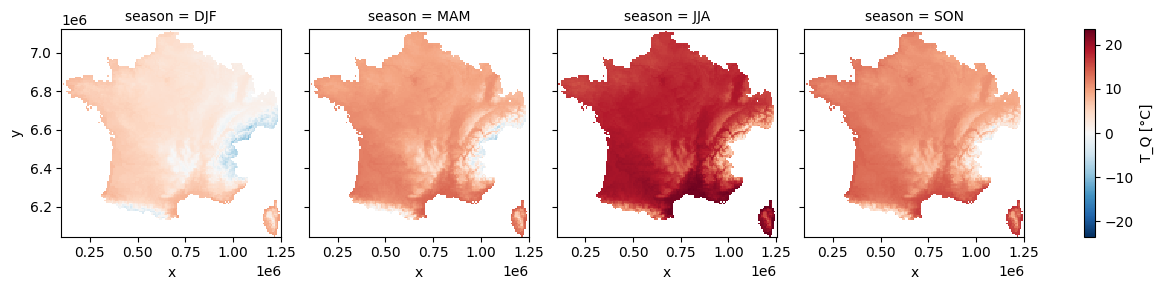

In [94]:
print('Année 1960-2023')
comparaison_saison(data,'T_Q')

Année 1960-1980
DJF moyenne saison: 3.0073743
MAM moyenne saison: 8.605742
JJA moyenne saison: 16.708685
SON moyenne saison: 10.364053


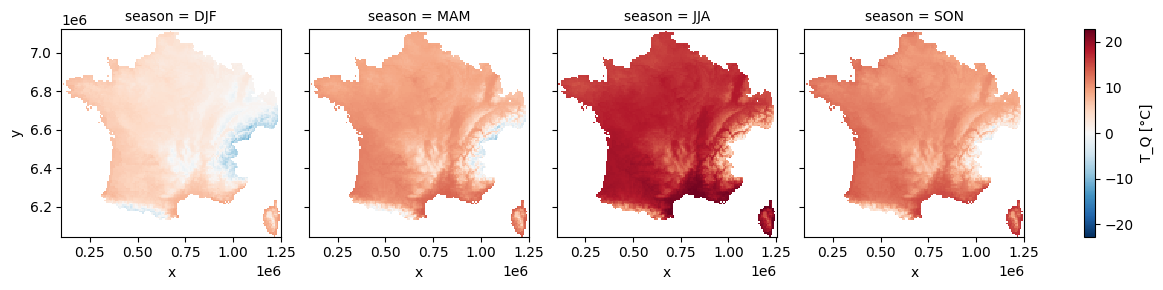

In [95]:
print('Année 1960-1980')
comparaison_saison(data1,'T_Q')

Année 2014-2023
DJF moyenne saison: 4.7394614
MAM moyenne saison: 10.185504
JJA moyenne saison: 19.050087
SON moyenne saison: 11.803185


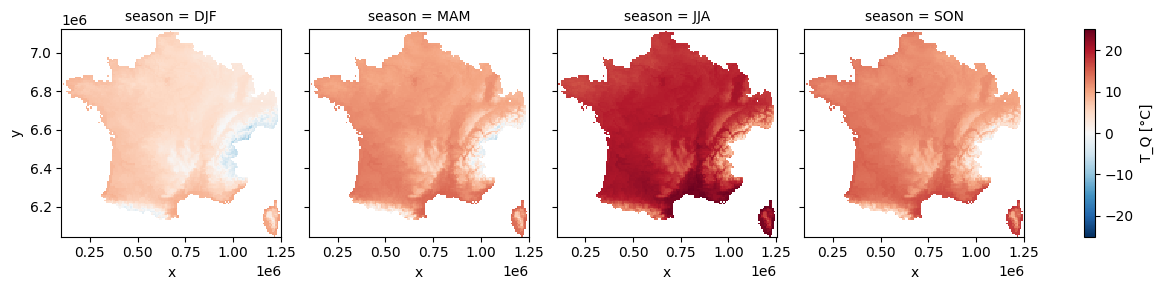

In [96]:
print('Année 2014-2023')
comparaison_saison(data2,'T_Q')

Des idées de plots plus pertinent ? Ouvrez une issue sur github : en haut à droite

## Autres jeu de données, le rpg

In [97]:
coord='149814,6770610,207232,6829612'

In [98]:
%%time
param='code_culture'
r=requests.get('https://api.geosas.fr/edr/collections/RPG-Raster/cube?bbox='+coord+'&crs=EPSG:2154&parameter-name=code_culture&f=Netcdf4&datetime=2010-01-01')


CPU times: user 247 ms, sys: 157 ms, total: 404 ms
Wall time: 1.19 s


In [99]:
test=xr.open_dataset(r.content)
test

<xarray.Dataset>
Dimensions:       (y: 5900, x: 5742, time: 1)
Coordinates:
  * y             (y) float64 6.771e+06 6.771e+06 ... 6.83e+06 6.83e+06
  * x             (x) float64 1.498e+05 1.498e+05 ... 2.072e+05 2.072e+05
  * time          (time) datetime64[ns] 2010-01-01
Data variables:
    code_culture  (time, y, x) float32 ...
Attributes:
    crs:          EPSG:2154
    description:  Cette API reconstitue l’histoire culturale de Bretagne, ell...
    id:           RPG-Raster
    title:        Registre Parcellaire Graphique (RPG), rasterisé
    rel:          https://geoservices.ign.fr/sites/default/files/2023-02/REF_...

In [107]:
test=test.isel(time=0)

CPU times: user 507 ms, sys: 124 ms, total: 630 ms
Wall time: 630 ms


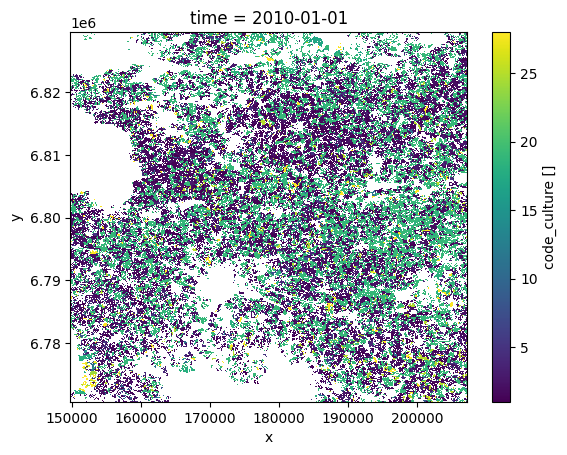

In [108]:
%%time
test.code_culture.plot.imshow()

Exemple avec datashaders utile pour les gros jeux de données, avec la possibilité de choisir le mode d'aggrégation (moyenne, min,max,mode..)

In [104]:
from colorcet import palette
from datashader import utils
import datashader as ds
from datashader import transfer_functions as tf, reductions as rd

In [110]:
%%time
coord='25129,6033881,1319206,7310535'
param='code_culture'
r=requests.get('https://api.geosas.fr/edr/collections/RPG-Raster/cube?bbox='+coord+'&crs=EPSG:2154&parameter-name=code_culture&f=Netcdf4&datetime=2010-01-01')


CPU times: user 3.38 s, sys: 2.44 s, total: 5.82 s
Wall time: 14.2 s


In [114]:
test=xr.open_dataset(r.content)
test=test.isel(time=0)

In [111]:
cmap=[ '#D9D9D9',  '#BC80BD',  '#CCEBC5', '#FFED6F',  '#CB25C5',  '#8DD3C7', '#8DD3C7',  '#FFFFB3', '#FDB462', '#FB8072','#FDB462','#B3DE69', '#09E33D',
       '#09E33D', '#B3DE69','#80B1D3', '#FDB462', '#FDB462', '#FCCDE5', '#e85151', '#FDB462']

CPU times: user 5.81 s, sys: 1.04 s, total: 6.85 s
Wall time: 3.47 s


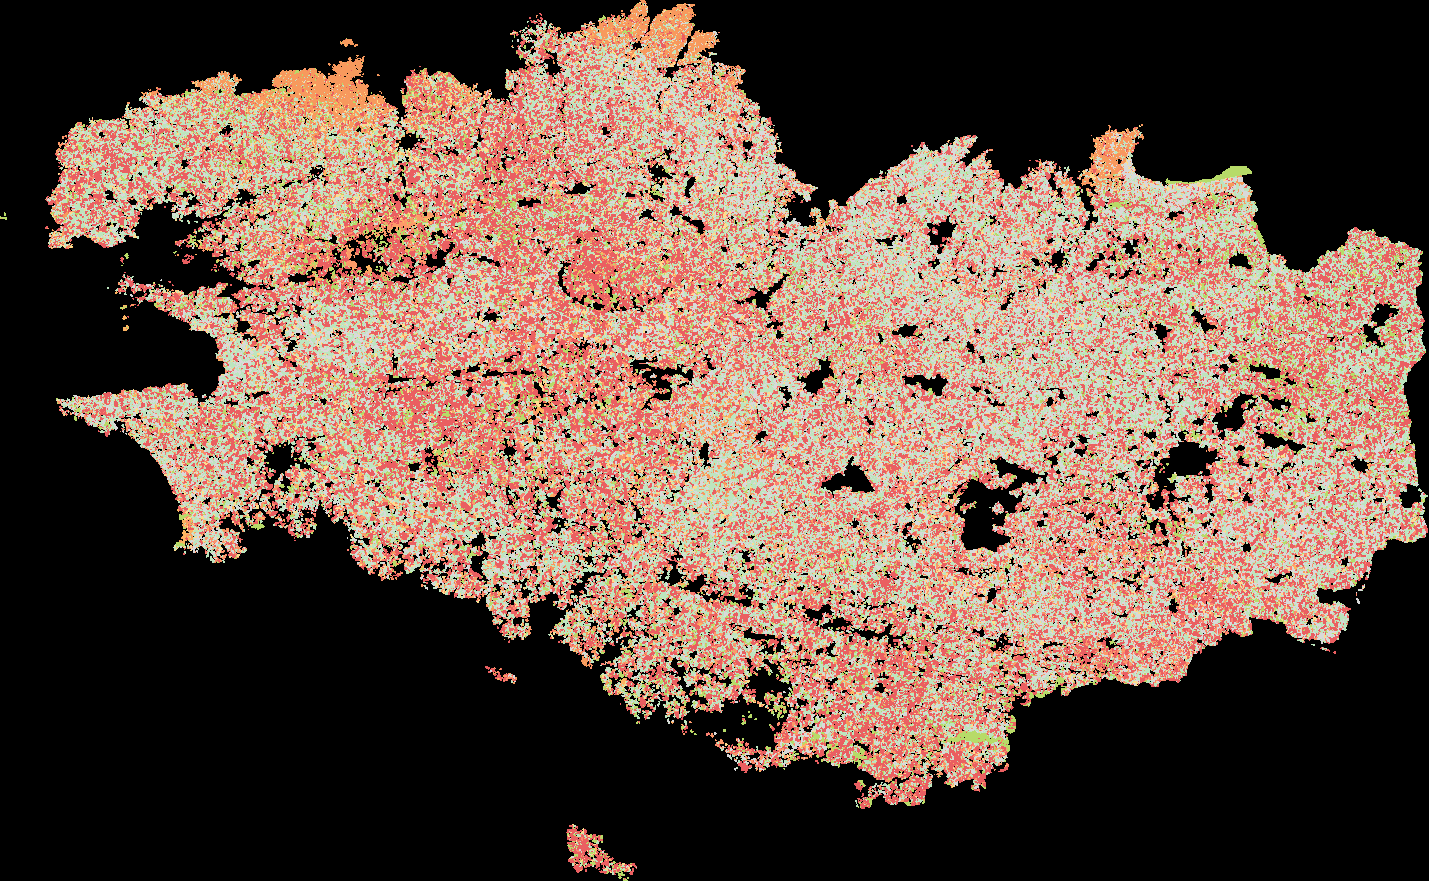

In [115]:
%%time
#cmap = palette['kgy']
bg_col = 'black'
xs, ys = int(test.sizes['x']*0.05), int(test.sizes['y']*0.05)
cvs = ds.Canvas(plot_width=xs, plot_height=ys)
img =tf.shade(cvs.raster(test, agg=rd.mode('code_culture')), cmap=cmap)
img = tf.set_background(img, bg_col)
utils.export_image(img=img, filename='rpg', fmt=".png",
                    background=None)
